In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys,os,json
sys.path.append(os.path.abspath('../../models/PFIN'))
sys.path.append(os.path.abspath('../../fastjet-install/lib/python3.9/site-packages'))
from dataset_pfn import PFNDataset, processed2tau
from PFIN import PFIN as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#Training/Testing path
preprocessed=True
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [3]:
modelname = "../../models/PFIN/trained_models/PFIN_best_v3_cat"
model_dict = json.load(open(modelname.replace("trained_models/", "trained_model_dicts/").replace("_best", "") + ".json"))
phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))
f_nodes = list(map(int, model_dict['f_nodes'].split(',')))
n_phiI = model_dict['n_phiI']
label = model_dict['label']
Np = model_dict['Np']
x_mode = model_dict['x_mode']
augmented = model_dict['augmented']


model = Model(particle_feats = 3, 
              Phi_sizes=phi_nodes, 
              F_sizes = f_nodes,
              n_consts = Np,
              PhiI_nodes = n_phiI,
              interaction_mode = x_mode,
              augmented = augmented)
model.load_state_dict(torch.load(modelname))
model = model.cuda()
model.eval()

[100, 100, 64] [64, 100, 100]


PFIN(
  (phi): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (phiInt): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (phiInt2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=

In [4]:
test_set = PFNDataset(file_path = test_path, 
                      preprocessed = True,
                      n_constits = Np)
# test_data, test_mask, test_label = test_set[:]

In [5]:
def evalLatents(model, test_set):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l, ad, t) in enumerate(myDL):
            d = d.cuda()
            m = m.cuda()
            l = l.cuda()
            ad = ad.cuda()
            t = t.cuda()
            this_taus = processed2tau(d,ad)
            particle_embeddings = model.get_particle_embeddings(d, m)
            interaction_embeddings = model.get_interaction_embeddings(d, ad, m)
            if model.x_mode == 'sum':
                latent_embeddings = particle_embeddings.sum(-1) + interaction_embeddings.sum(-1)
            else:
                latent_embeddings = torch.cat([particle_embeddings, interaction_embeddings], 1).sum(-1)
            if model.augmented:
                this_preds = model.fc(torch.cat([latent_embeddings, t], 1))
            else:
                this_preds = model.fc(latent_embeddings)
            if idx == 0:
                latents = latent_embeddings.cpu()
                labels = l.cpu()
                # presoftmax = psmax.cpu()
                preds = this_preds.cpu()
                aug_data = ad.cpu()
                taus = this_taus.cpu()
            else:
                latents = torch.cat((latents, latent_embeddings.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                # presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, this_preds.cpu()), 0)
                aug_data = torch.cat((aug_data, ad.cpu()), 0)
                taus = torch.cat((taus, this_taus.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, preds, aug_data, taus

In [6]:
latents, labels, preds, aug_data, taus = evalLatents(model, test_set)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [7]:
auc_baseline = roc_auc_score(labels[:, 1].numpy(), preds[:, 1].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 98.3627%


In [8]:
pca = PCA(n_components=0.99)
pca.fit(latents)

PCA(n_components=0.99)

In [9]:
latents_pca = pca.fit_transform(latents)
latents_pca.shape

(103424, 52)

In [10]:
bkg_indices = (labels[:, 0] == 1).numpy()
sig_indices = (labels[:, 1] == 1).numpy()

/tmp/ipykernel_470305/61330557.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))


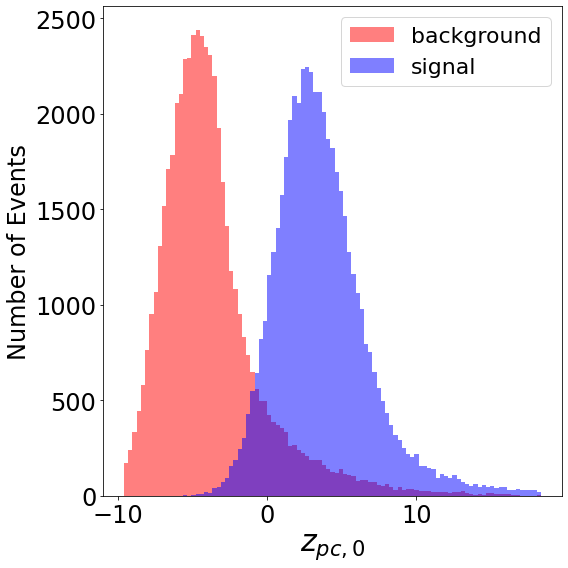

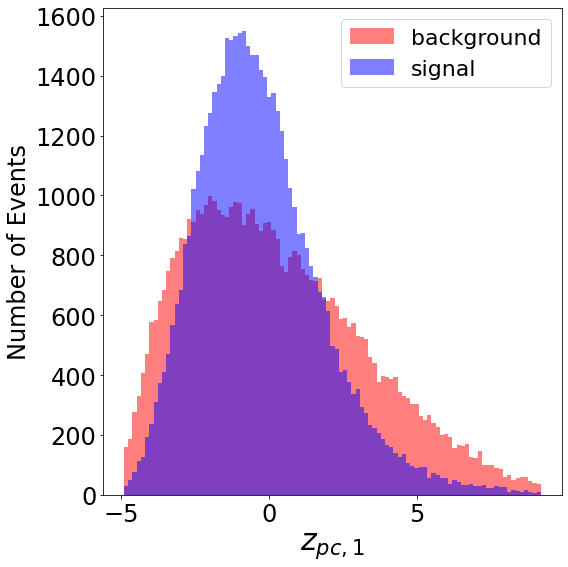

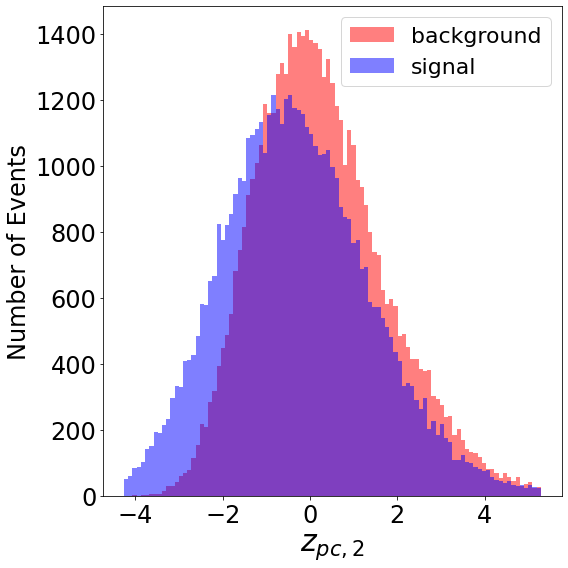

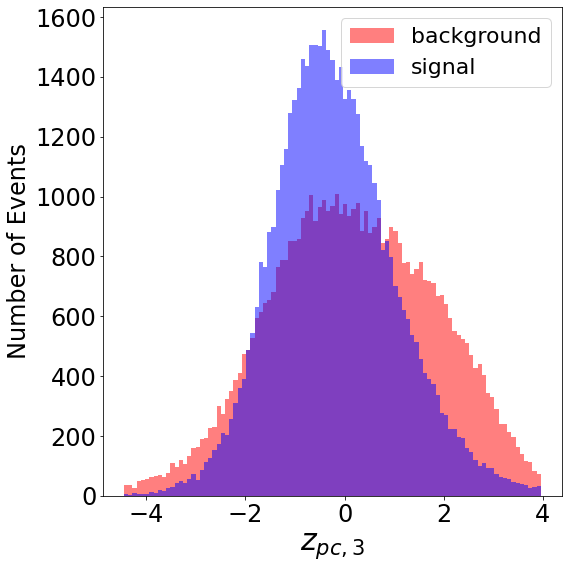

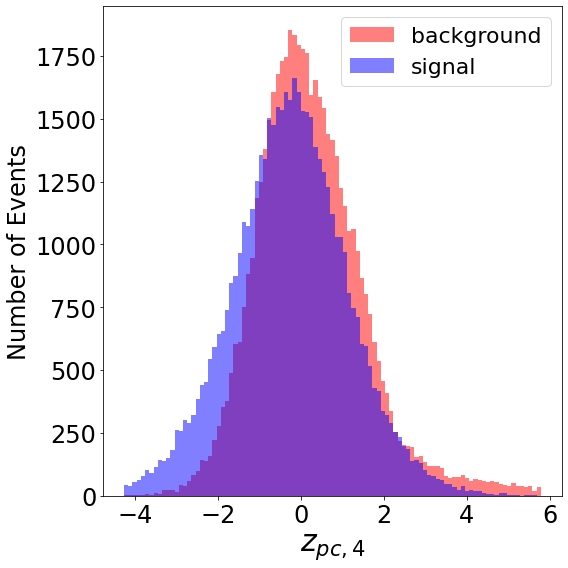

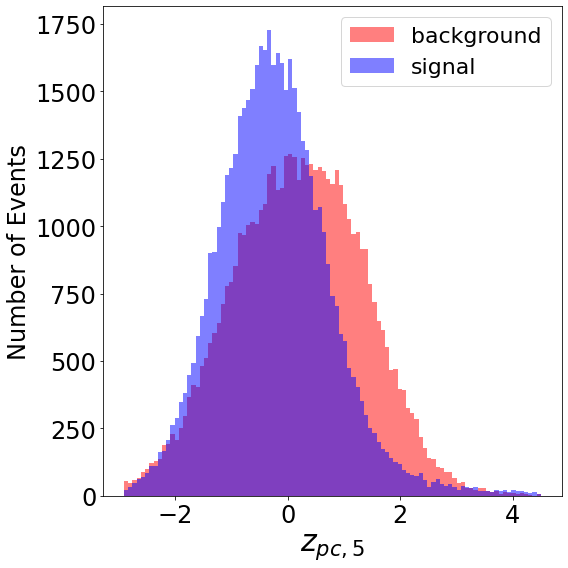

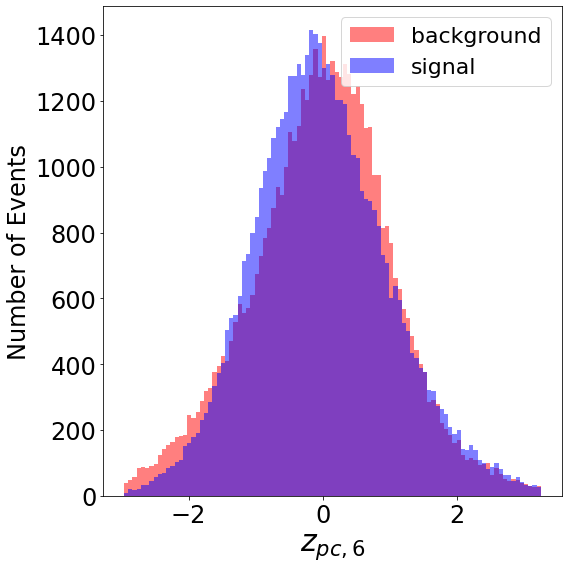

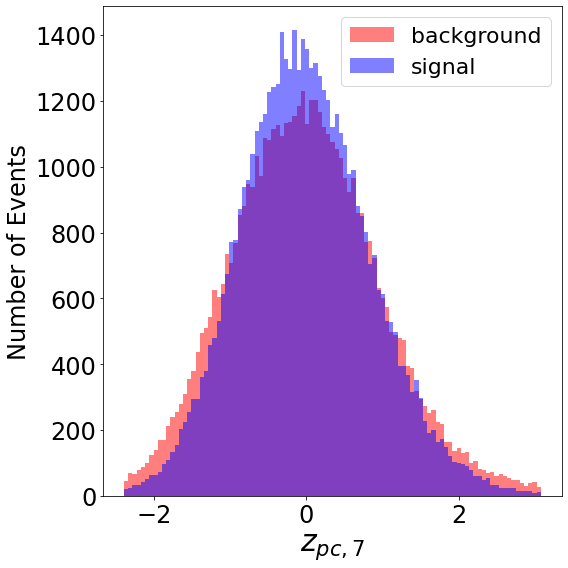

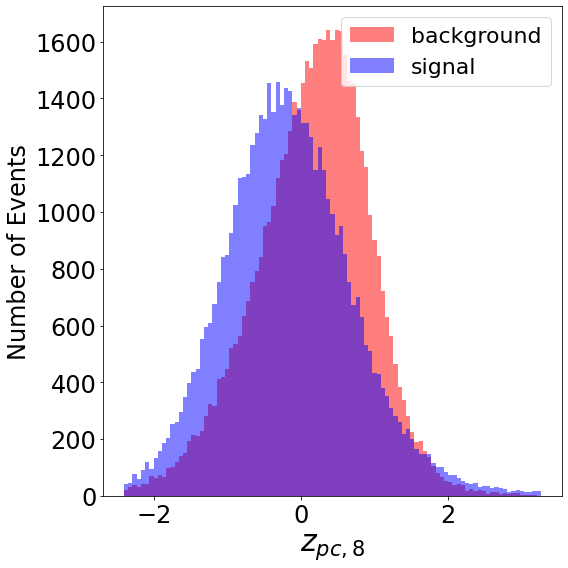

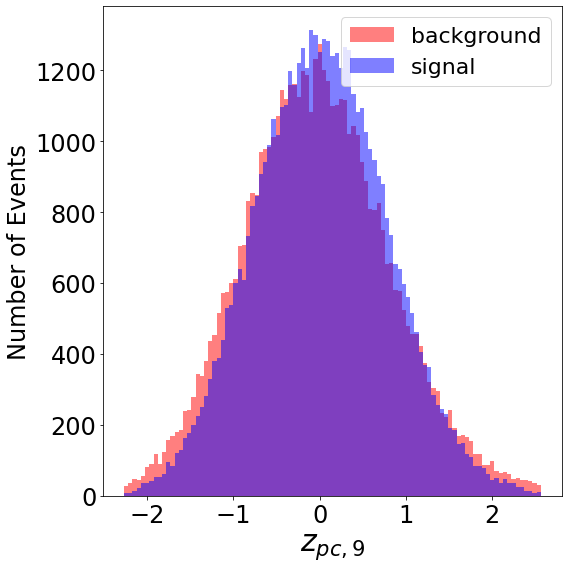

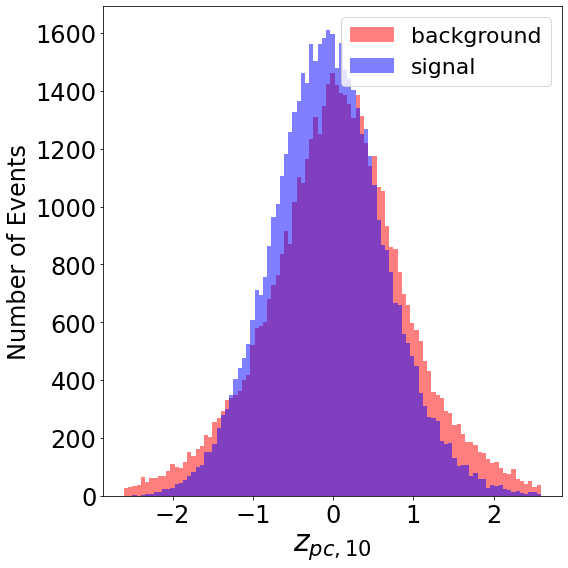

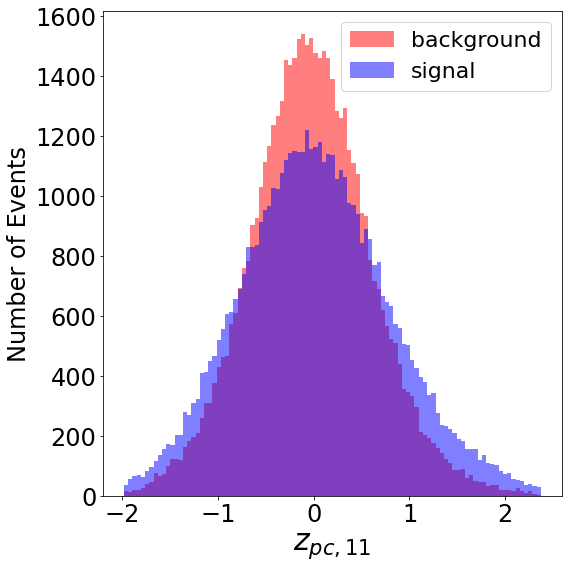

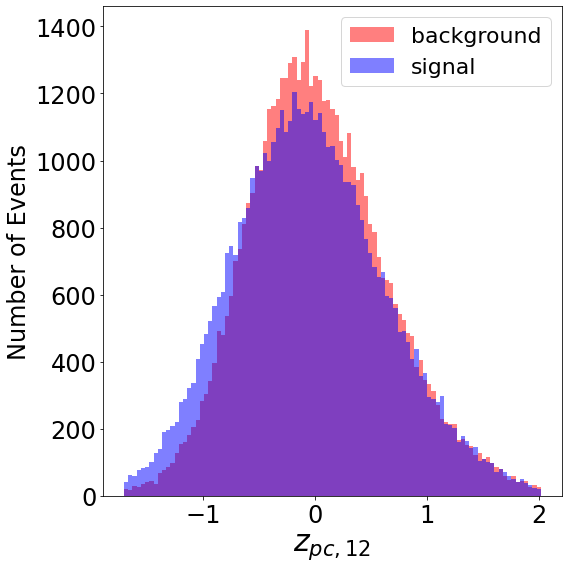

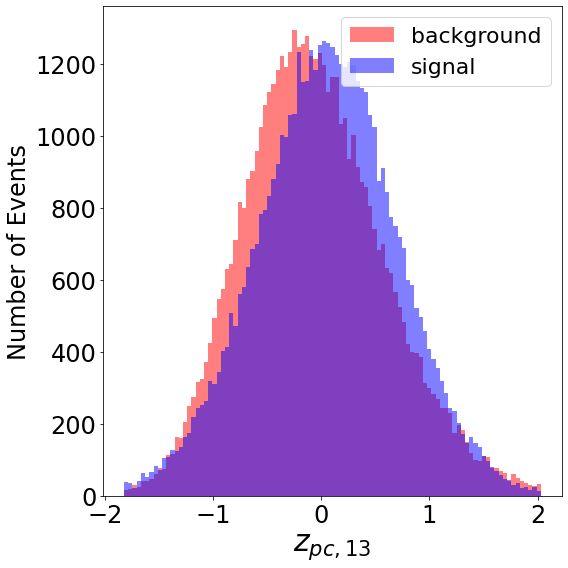

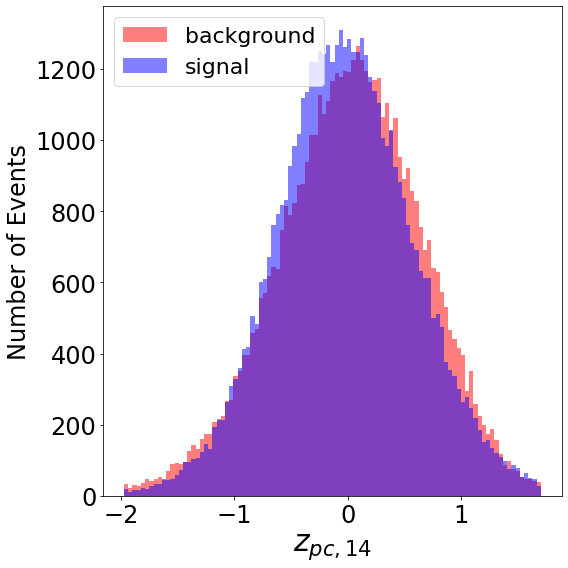

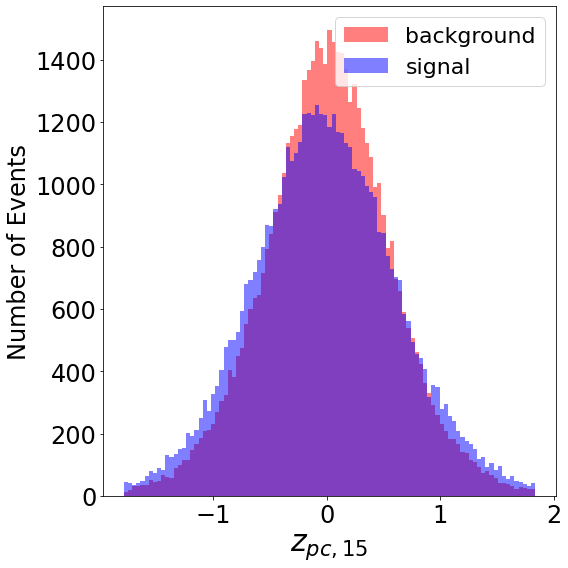

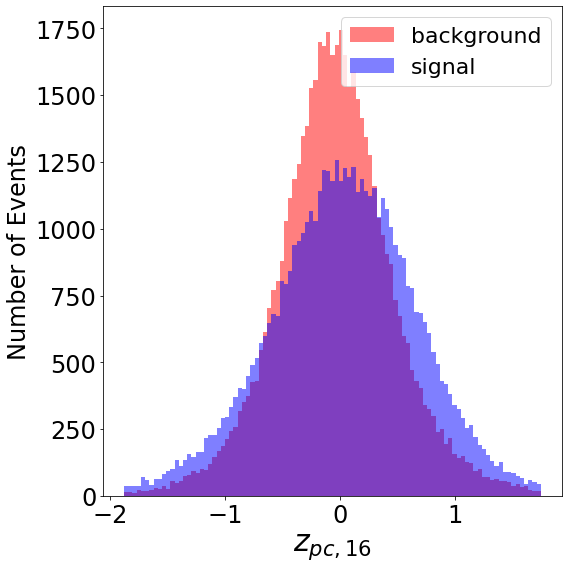

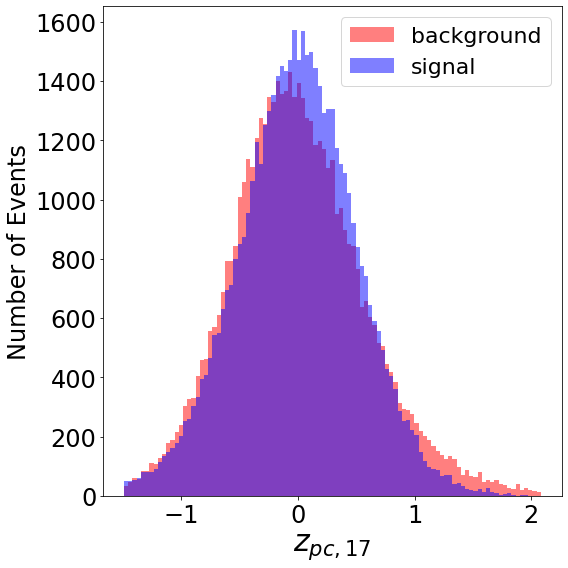

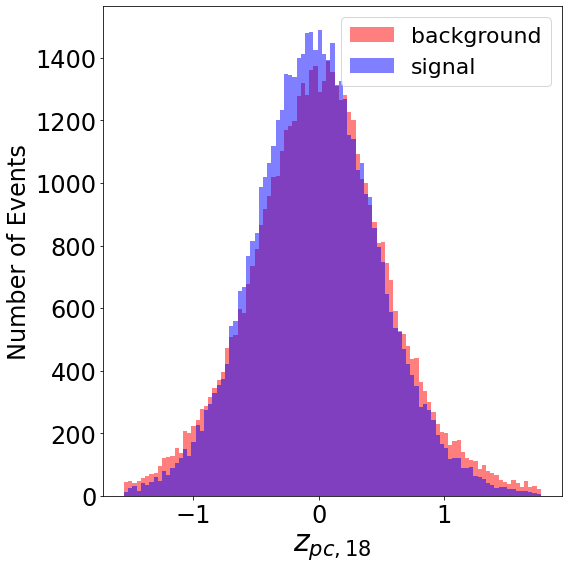

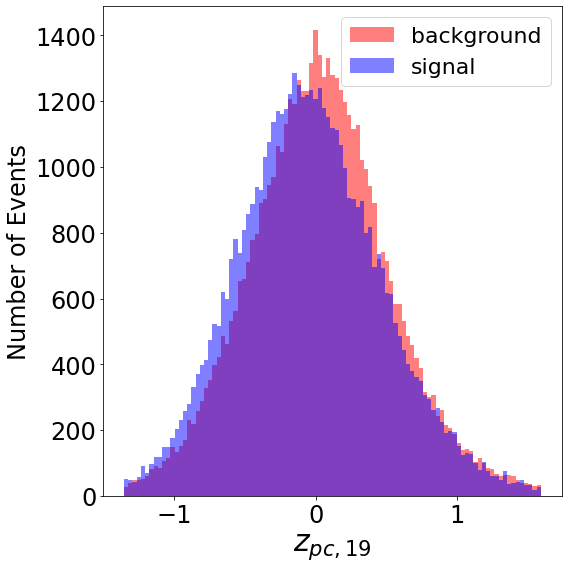

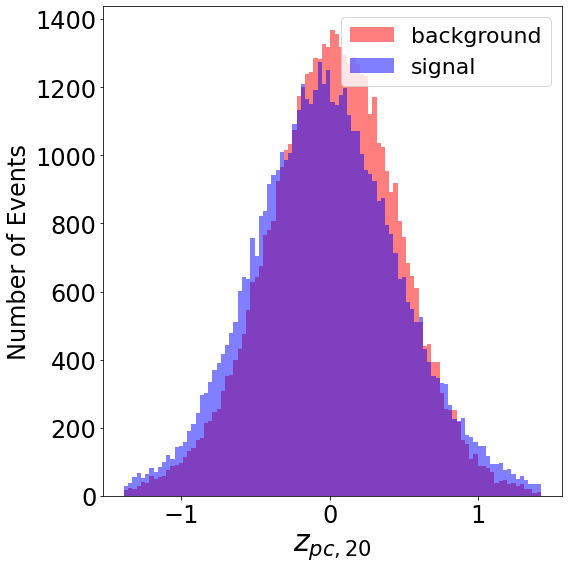

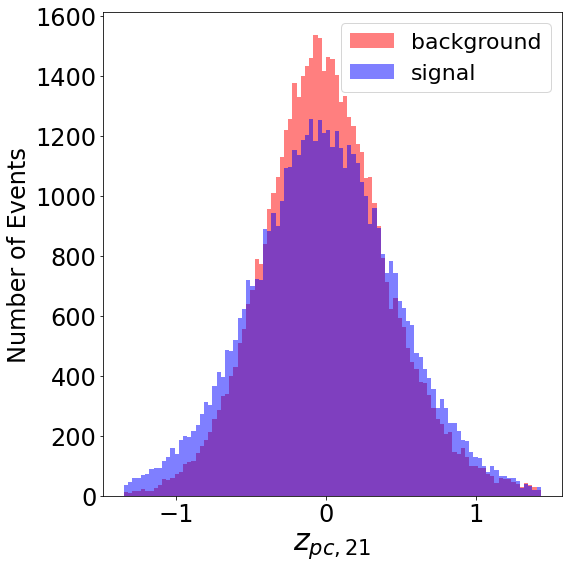

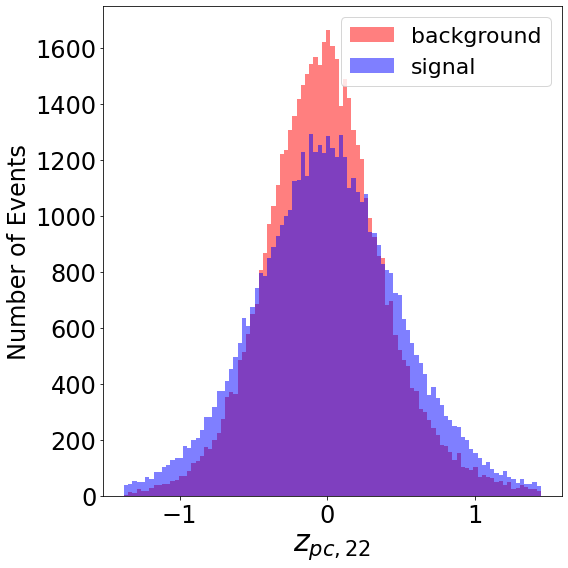

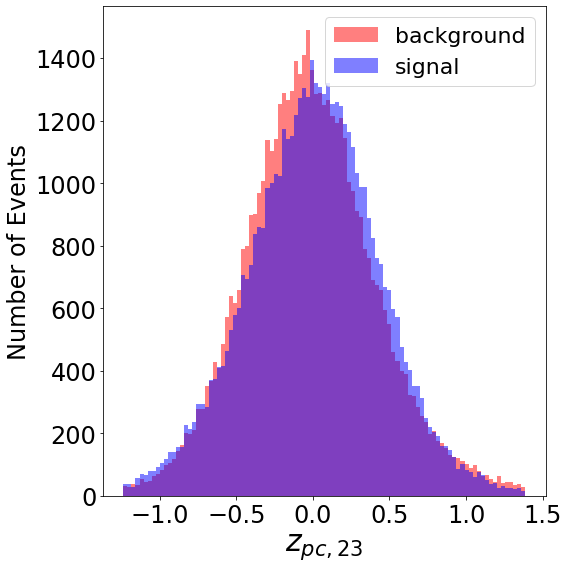

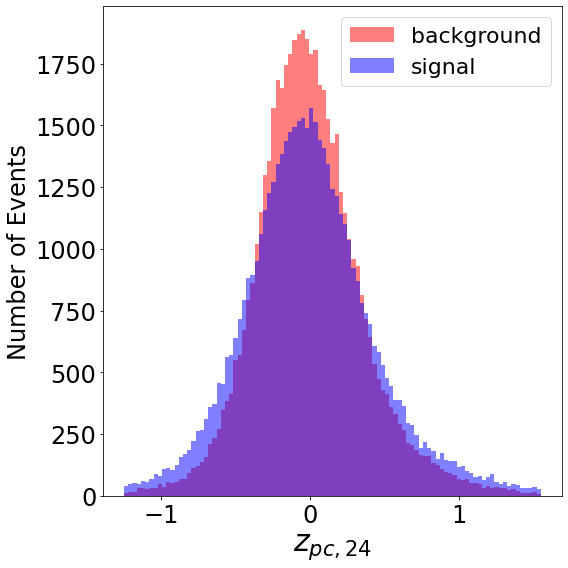

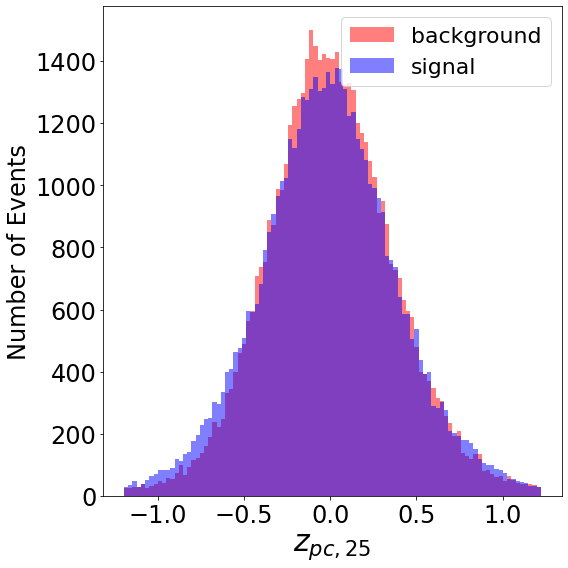

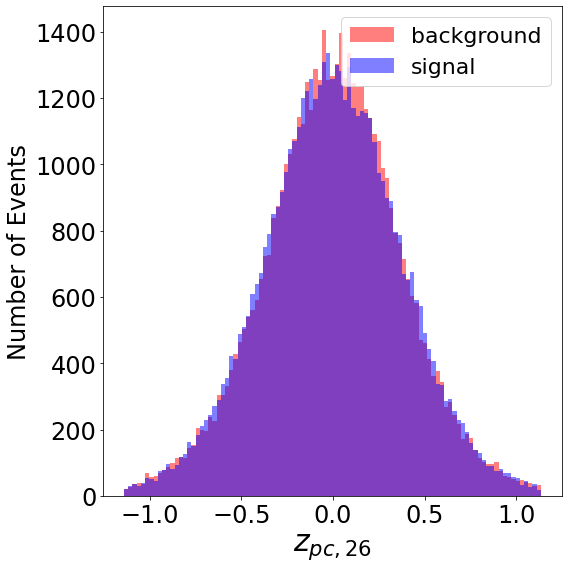

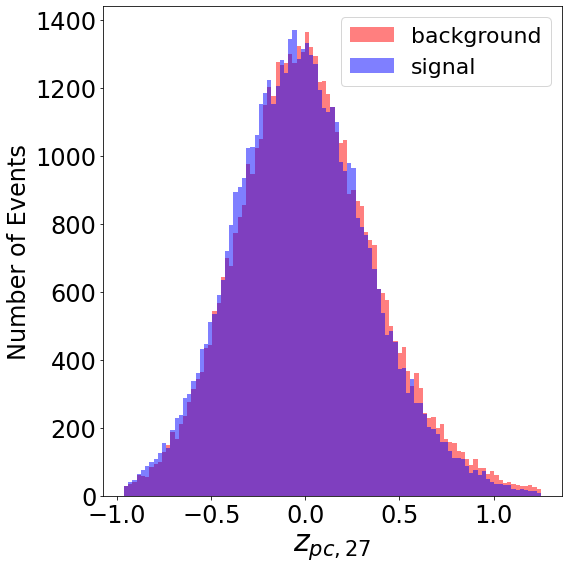

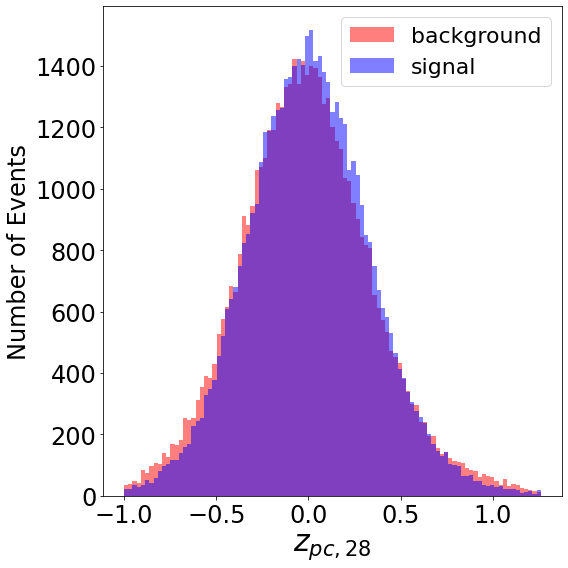

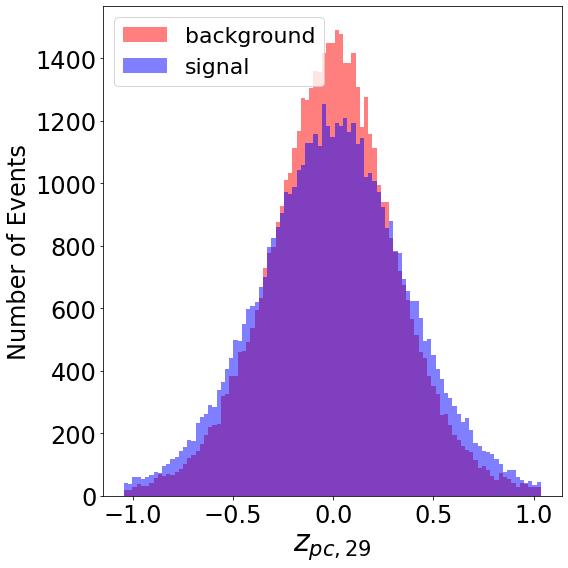

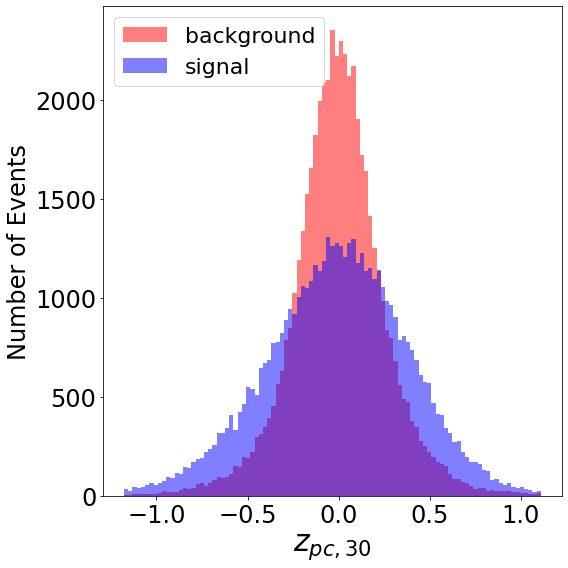

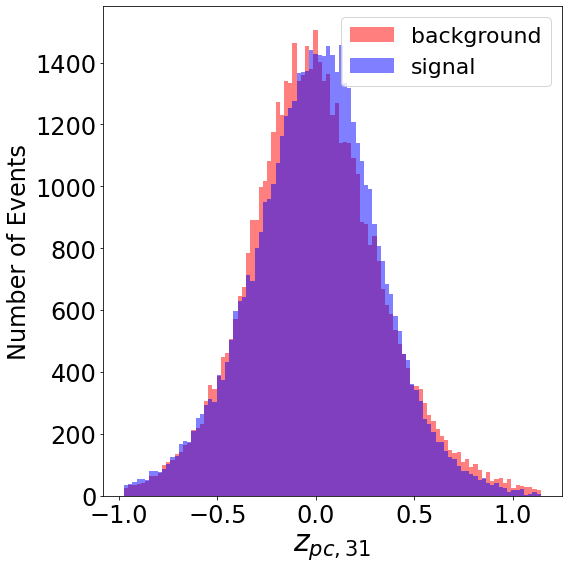

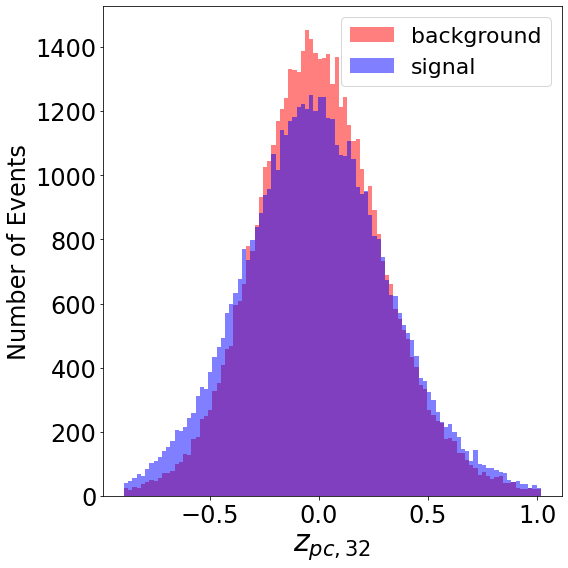

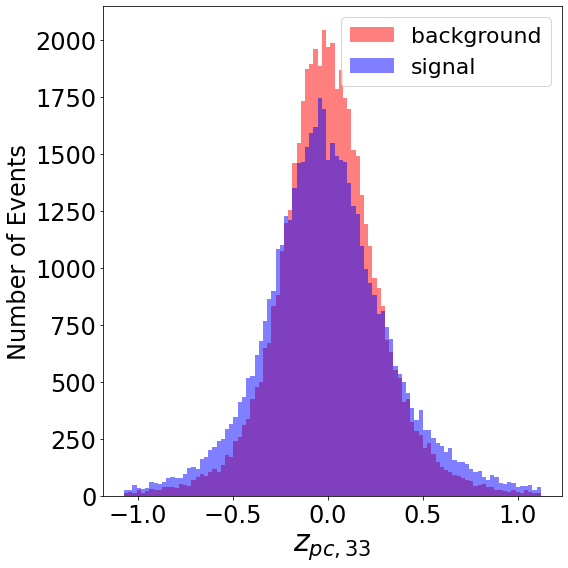

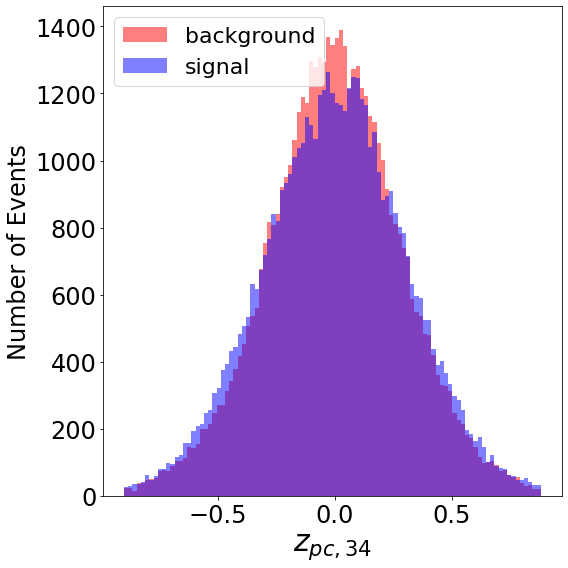

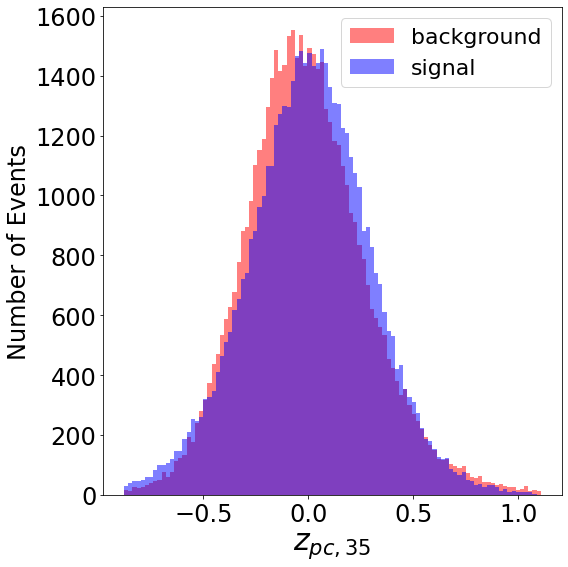

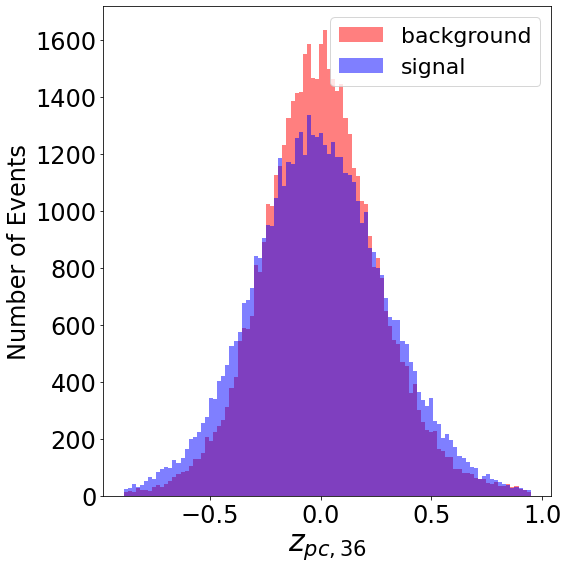

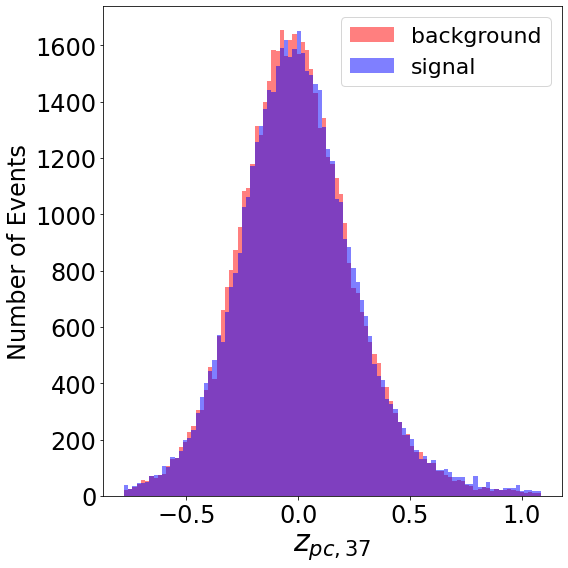

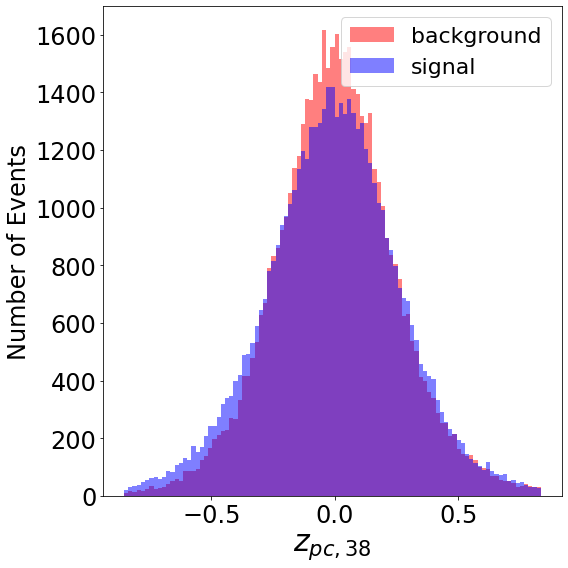

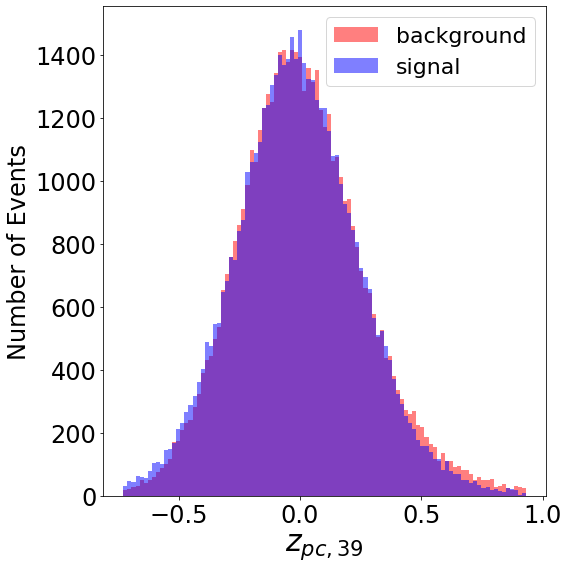

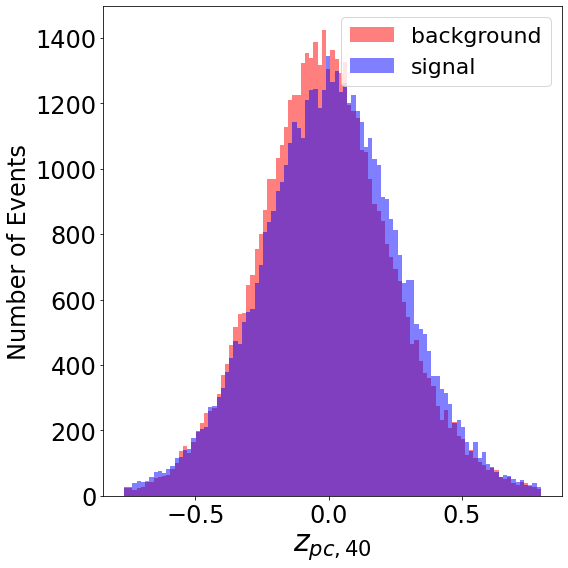

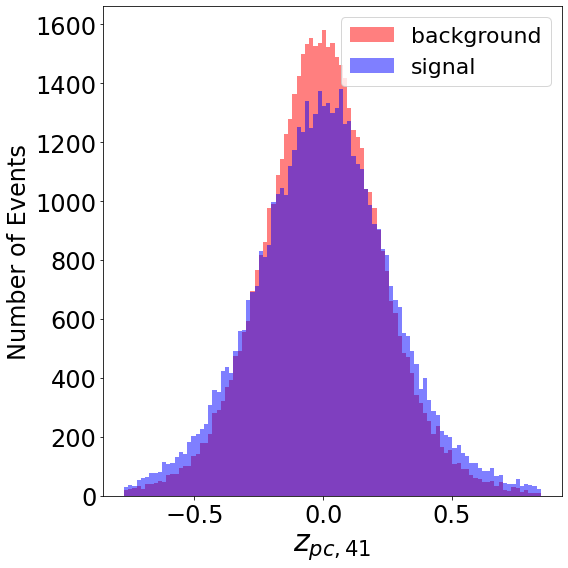

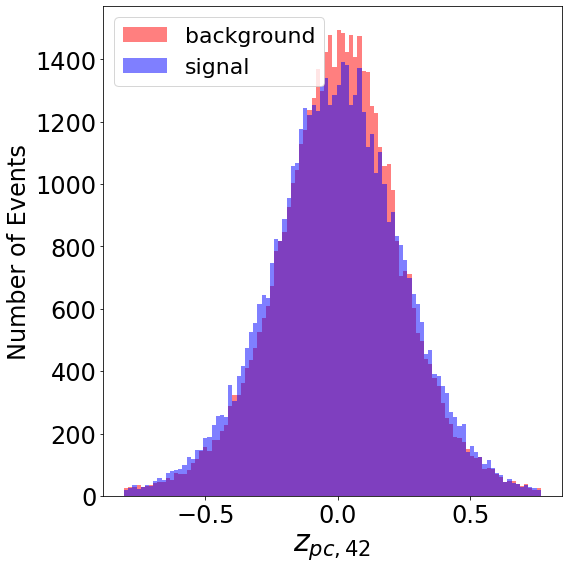

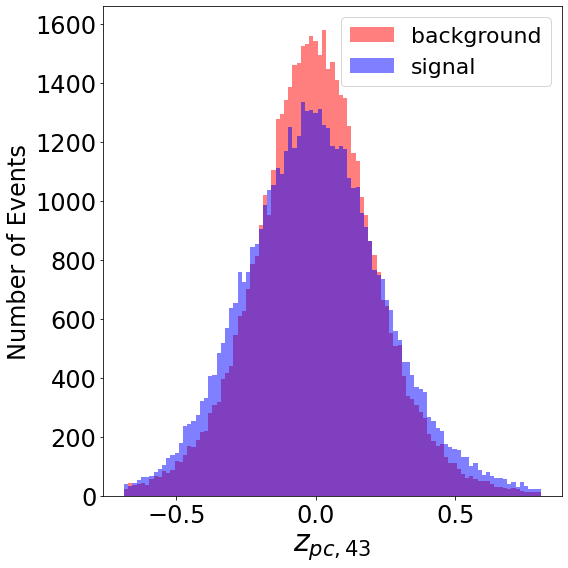

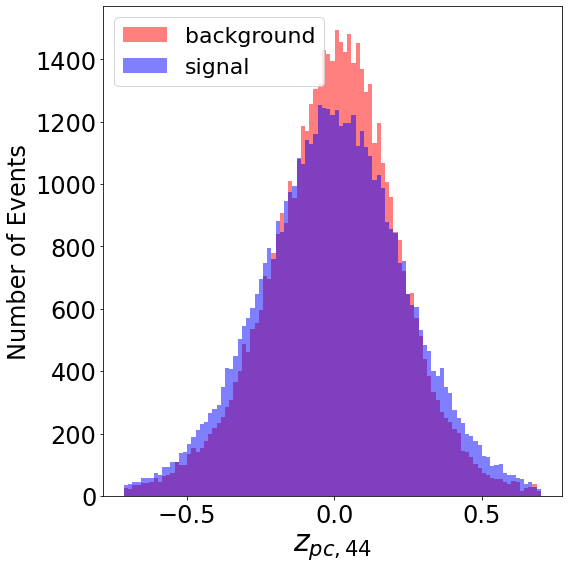

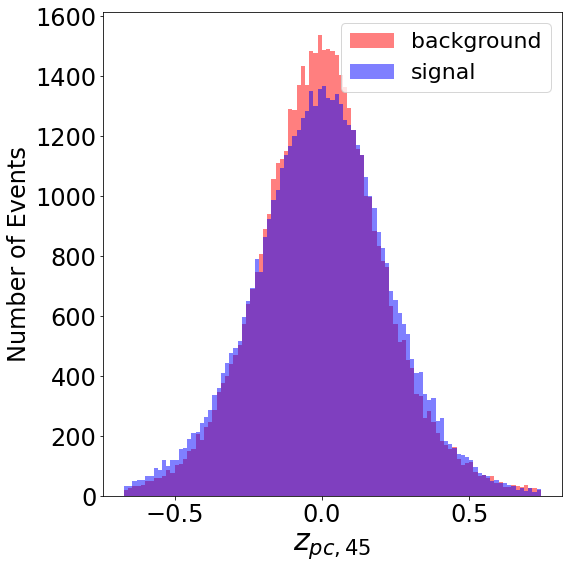

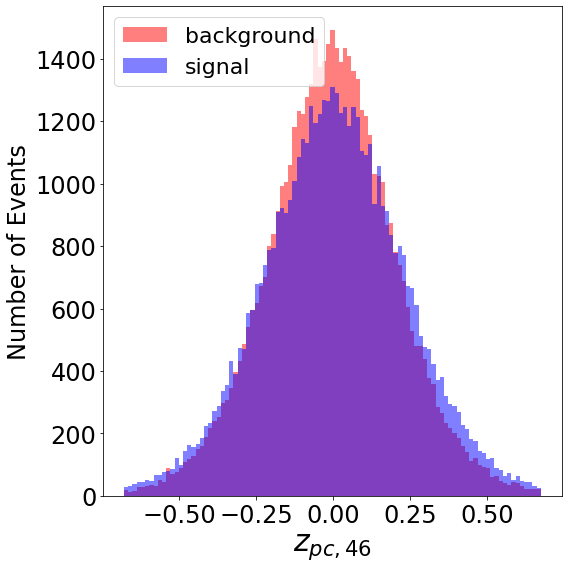

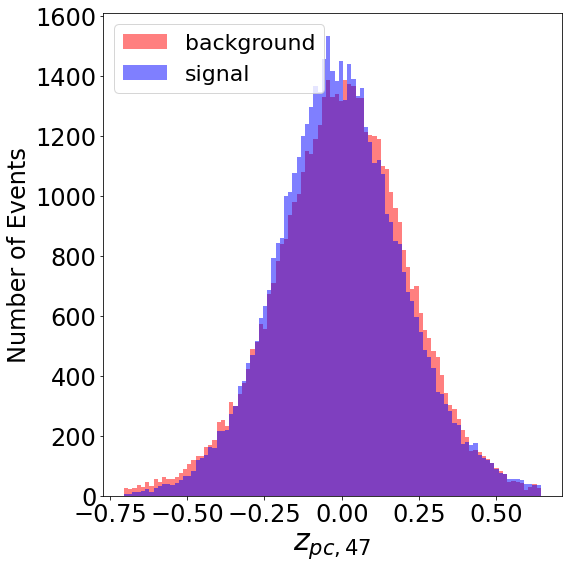

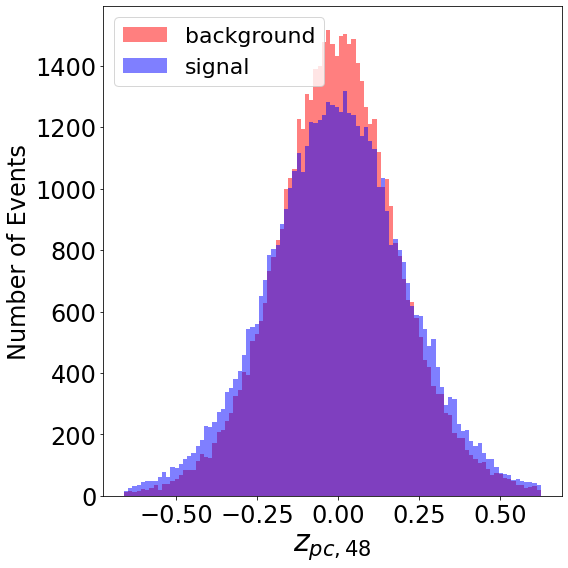

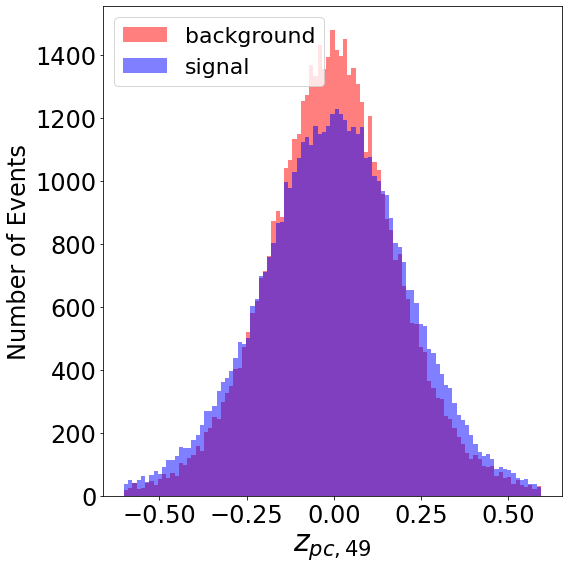

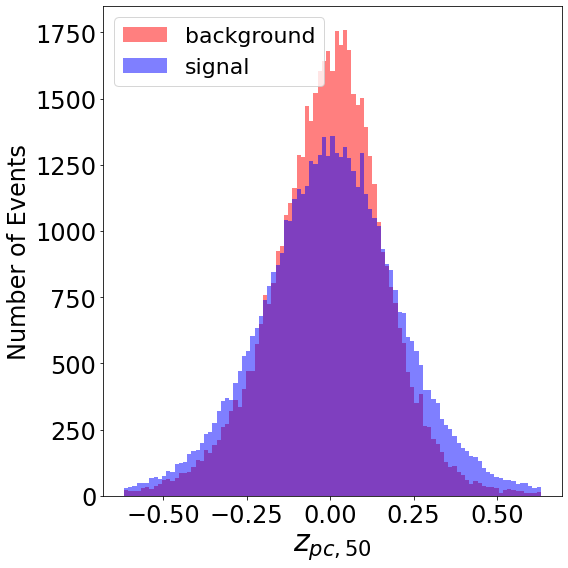

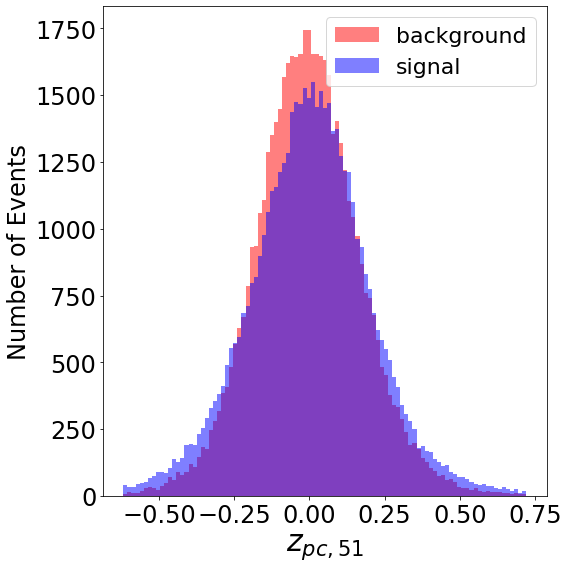

In [11]:
Nz_pca = latents_pca.shape[1]
pc2plot = list(range(Nz_pca))
for ii in pc2plot:
    plt.figure(figsize=(8,8))
    bkg_data = latents_pca[bkg_indices, ii]
    sig_data = latents_pca[sig_indices, ii]
    
    mr = max(np.percentile(bkg_data, 99.5), np.percentile(sig_data, 99.5))
    ml = min(np.percentile(bkg_data, 0.5), np.percentile(sig_data, 0.5))
    m = mr - ml
    plt.hist(bkg_data, bins=np.arange(ml,mr,m/100), label='background', color='red', alpha=0.5)
    plt.hist(sig_data, bins=np.arange(ml,mr,m/100), label='signal', color='blue', alpha=0.5)
    plt.xlabel('$z_{pc,' + '{}'.format(ii) + '}$', fontsize=30)
    plt.ylabel("Number of Events", fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(fontsize = 22)
    plt.tight_layout()
    plt.savefig("figures/zpca_{}_{}.pdf".format(ii, label))

In [12]:
aug_cols = ['jet_e', 'jet_m', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_ptsum', 'jet_nconst']
print(aug_data.shape)
print(len(aug_cols))

torch.Size([103424, 7])
7


In [13]:
#jet_p = ((aug_data[:, 0]**2 - aug_data[:, 1]**2)**0.5).reshape(-1,1)
#jet_mt = ((aug_data[:, 1]**2 + aug_data[:, 1]**2)**0.5).reshape(-1,1)
aug_data = torch.cat((aug_data, taus, taus[:,1:2]/taus[:,0:1], taus[:,2:3]/taus[:,1:2]), 1)
aug_data.shape

torch.Size([103424, 17])

In [14]:
aug_cols += ['tau_{}_1'.format(i) for i in range(1,9)] + ['tau_21', 'tau_32']

In [15]:
pca_cols = ["zpca_{}".format(i) for i in range(latents_pca.shape[1])]

df_pca_bkg = pd.DataFrame(latents_pca[bkg_indices], columns = pca_cols)
df_pca_sig = pd.DataFrame(latents_pca[sig_indices], columns = pca_cols)
df_aug_bkg = pd.DataFrame(aug_data[bkg_indices], columns = aug_cols)
df_aug_sig = pd.DataFrame(aug_data[sig_indices], columns = aug_cols)

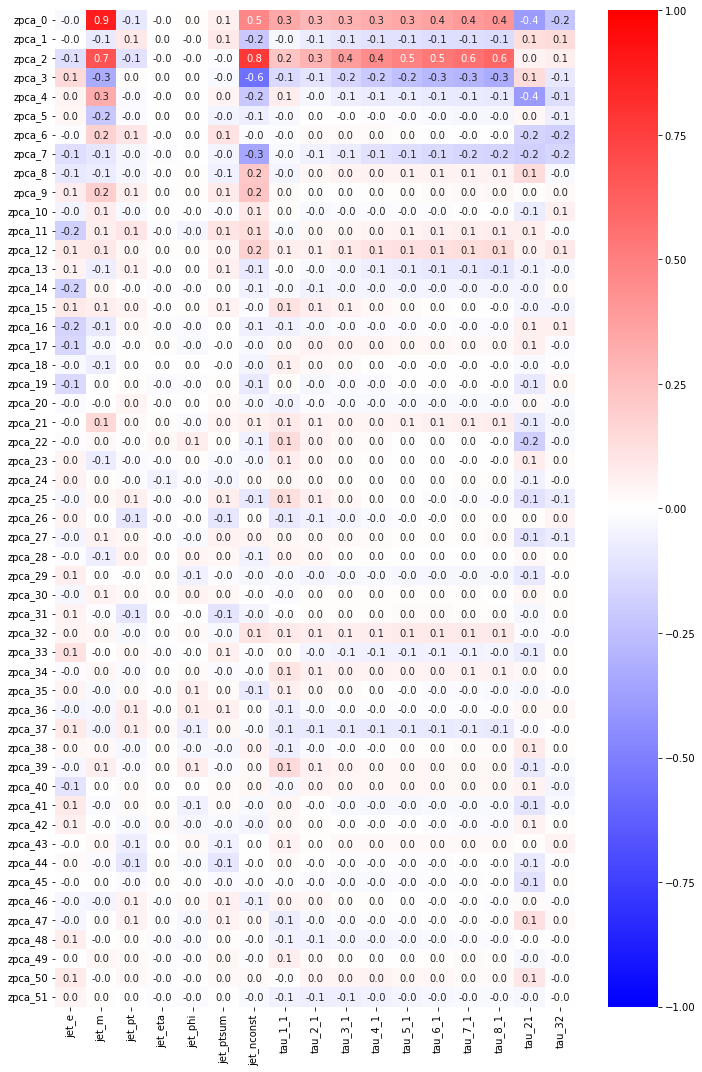

In [16]:
corrmat = pd.concat([df_pca_bkg, df_aug_bkg], axis=1).corr().loc[df_pca_bkg.columns, df_aug_bkg.columns]
plt.figure(figsize=(10,15))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()
# plt.savefig("figures/crosscorr_zpca_zaug_bkg.pdf")

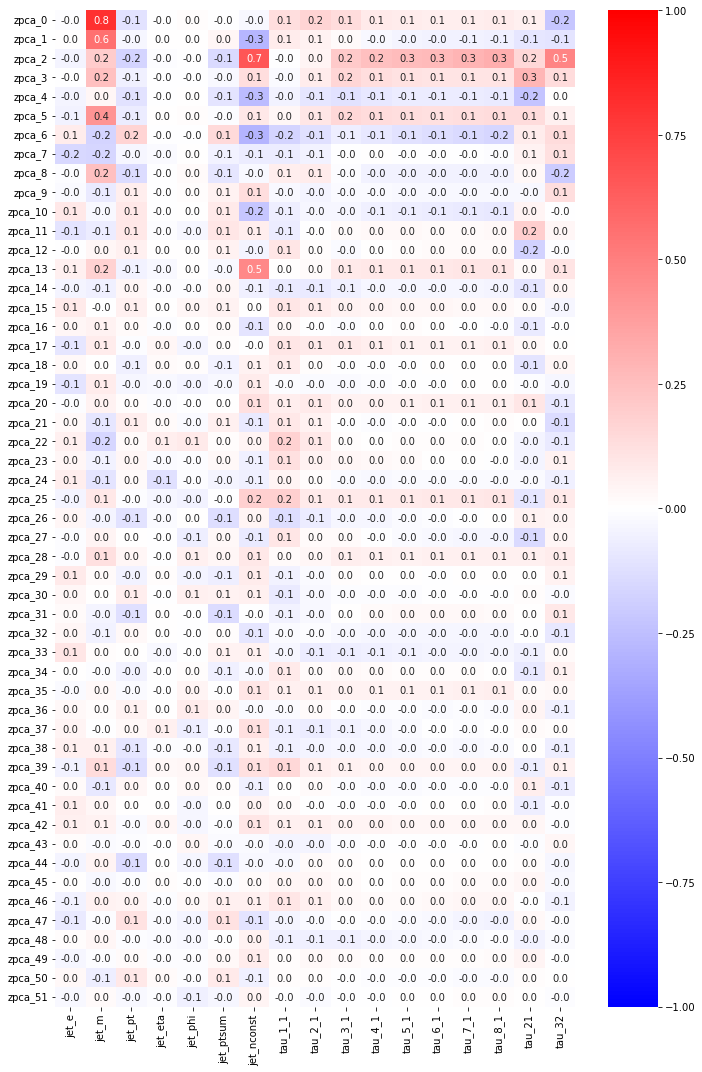

In [17]:
corrmat = pd.concat([df_pca_sig, df_aug_sig], axis=1).corr().loc[df_pca_sig.columns, df_aug_sig.columns]
plt.figure(figsize=(10,15))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()
# plt.savefig("figures/crosscorr_zpca_zaug_sig.pdf")